In [1]:
!pip install yfinance --quiet

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import pprint

Download historical daily stock prices using yfinance.

In [3]:
import yfinance as yf

# Download Tesla (TSLA) stock data
df = yf.download("TSLA", start="2019-01-01", end="2024-12-31")

# Keep only the 'Close' price and rename it to 'price'
df = df[['Close']].rename(columns={'Close': 'price'})

# Drop any missing values
df.dropna(inplace=True)

# Display the first rows
print(df.head())


/tmp/ipython-input-3-624592106.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TSLA", start="2019-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed

Price           price
Ticker           TSLA
Date                 
2019-01-02  20.674667
2019-01-03  20.024000
2019-01-04  21.179333
2019-01-07  22.330667
2019-01-08  22.356667


In [4]:
# Split
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Scale only on training data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['price']])
test_scaled = scaler.transform(test_df[['price']])

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def multi_step_metrics(y_true, y_pred):
    metrics = {}
    forecast_horizon = y_true.shape[1]
    for step in range(forecast_horizon):
        mse = mean_squared_error(y_true[:, step], y_pred[:, step])
        mae = mean_absolute_error(y_true[:, step], y_pred[:, step])
        rmse = sqrt(mse)
        mape = np.mean(np.abs((y_true[:, step] - y_pred[:, step]) / y_true[:, step])) * 100
        metrics[f"Step {step+1}"] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape
        }
    return metrics

In [11]:
df.head(10)

Price,price
Ticker,TSLA
Date,
2019-01-02,20.674667
2019-01-03,20.024000
2019-01-04,21.179333
2019-01-07,22.330667
2019-01-08,22.356667
2019-01-09,22.568666
2019-01-10,22.997999
2019-01-11,23.150667


- Visualize the Close price over time.

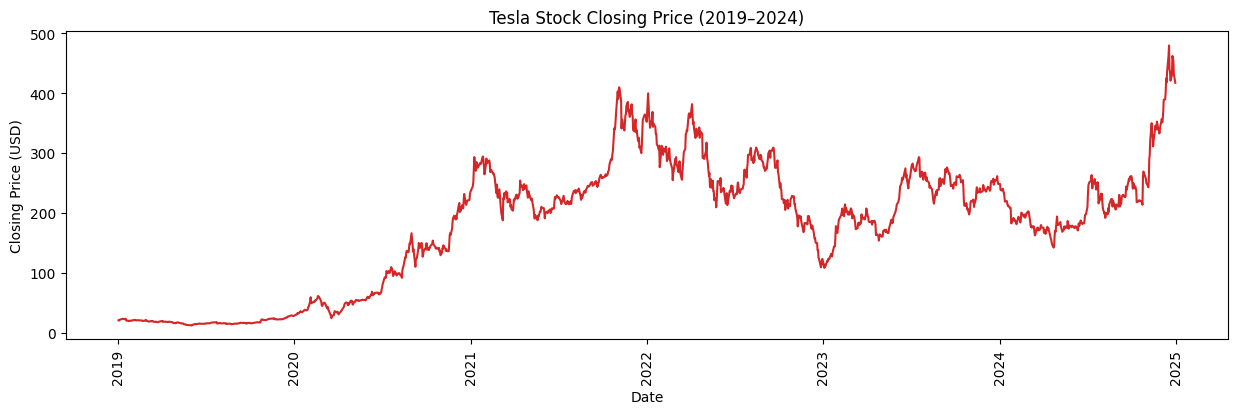

In [6]:
# Keep the same plot function
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Price', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')

    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xticks(rotation=90)
    plt.show()

# Call it for Tesla
plot_df(
    df,
    x=df.index,          # the index is the Date
    y=df['price'],       # your column is named 'price'
    title='Tesla Stock Closing Price (2019–2024)',
    ylabel='Closing Price (USD)'
)


 Calculate 7-day and 30-day moving averages

- Rolling moving averages (7-day, 30-day)

In [7]:
# 7-day moving average
df['MA7'] = df['price'].rolling(window=7).mean()

# 30-day moving average
df['MA30'] = df['price'].rolling(window=30).mean()


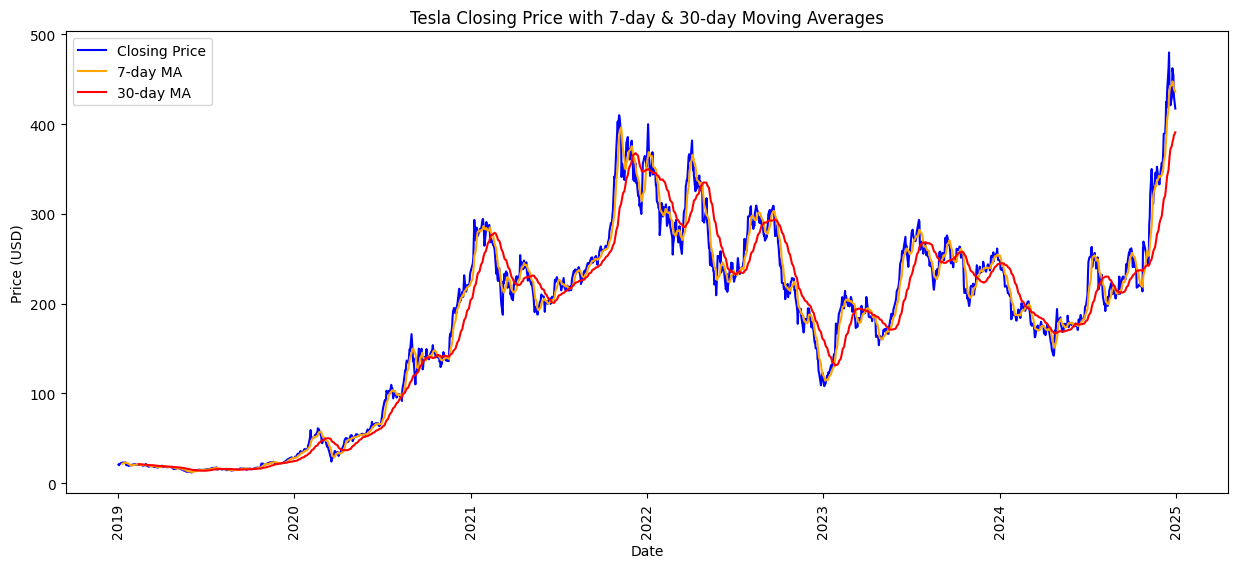

In [8]:
plt.figure(figsize=(15,6), dpi=100)

plt.plot(df.index, df['price'], label='Closing Price', color='blue')
plt.plot(df.index, df['MA7'], label='7-day MA', color='orange')
plt.plot(df.index, df['MA30'], label='30-day MA', color='red')

plt.title('Tesla Closing Price with 7-day & 30-day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=90)
plt.show()


7-day MA → short-term trend
Shows quick changes, more sensitive to recent price moves.


30-day MA → long-term trend
Smooths out more noise, shows the broader direction.

Seasonal decomposition of the series (using seasonal_decompose)

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [16]:
# !pip install statsmodels

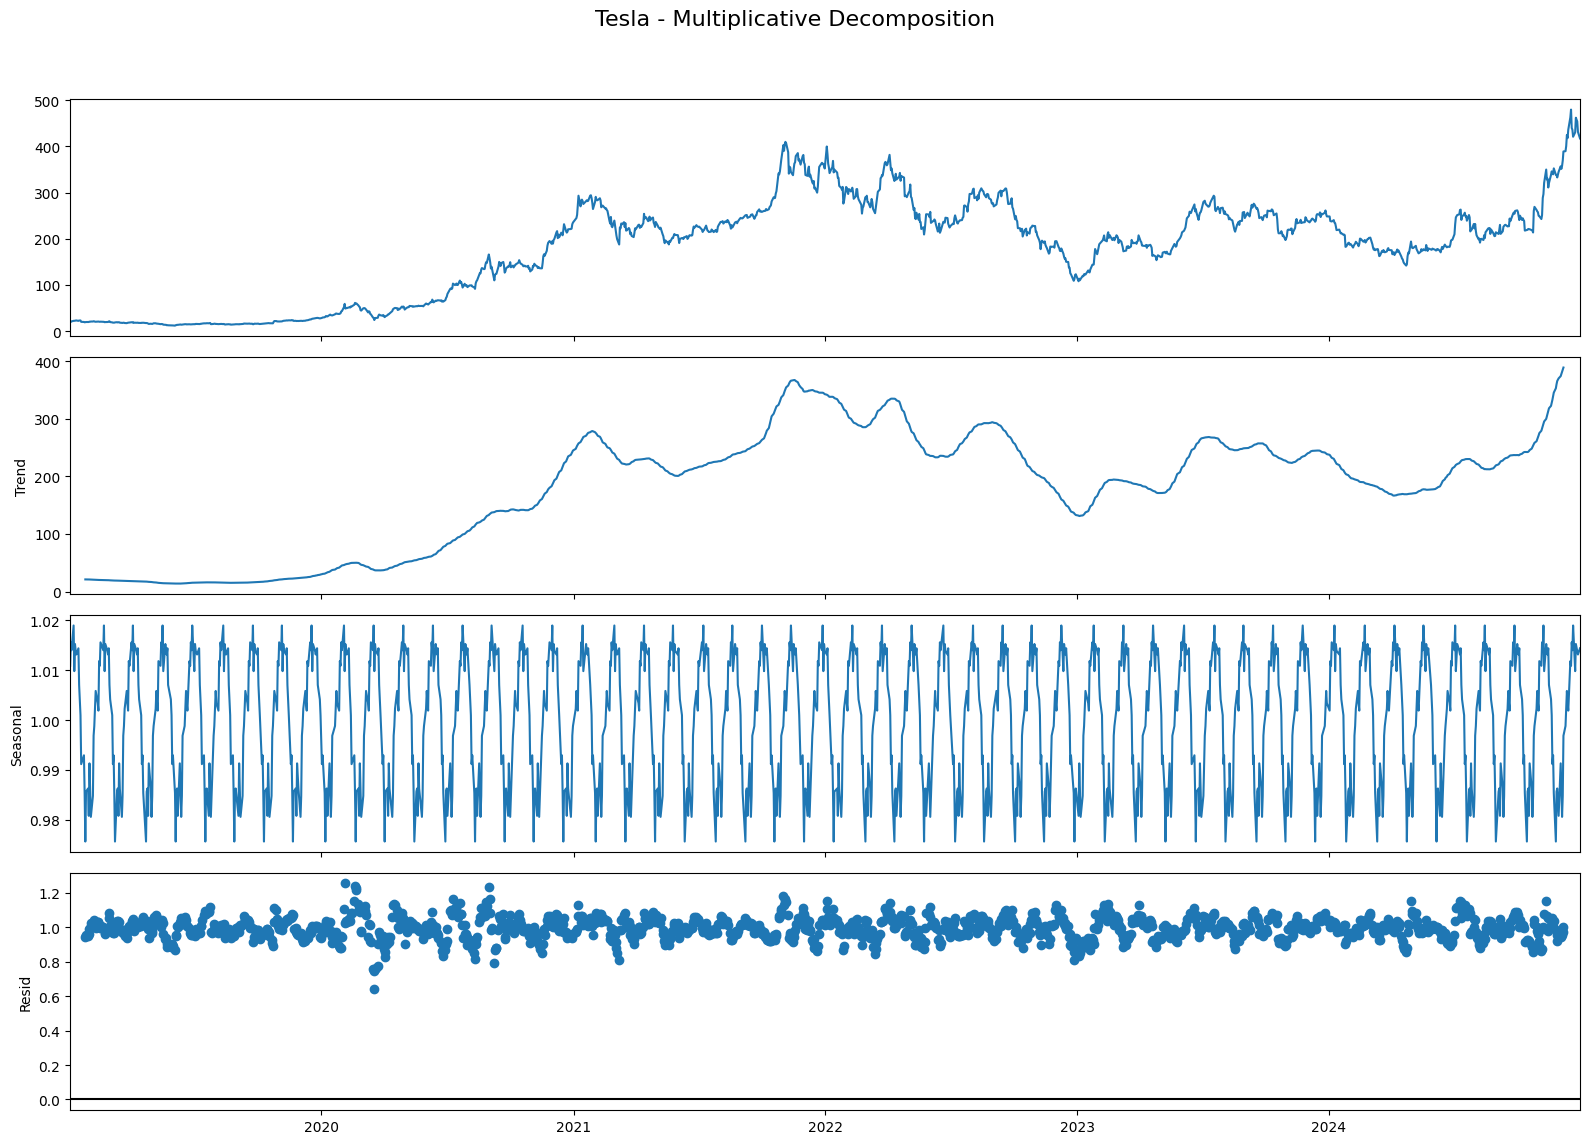

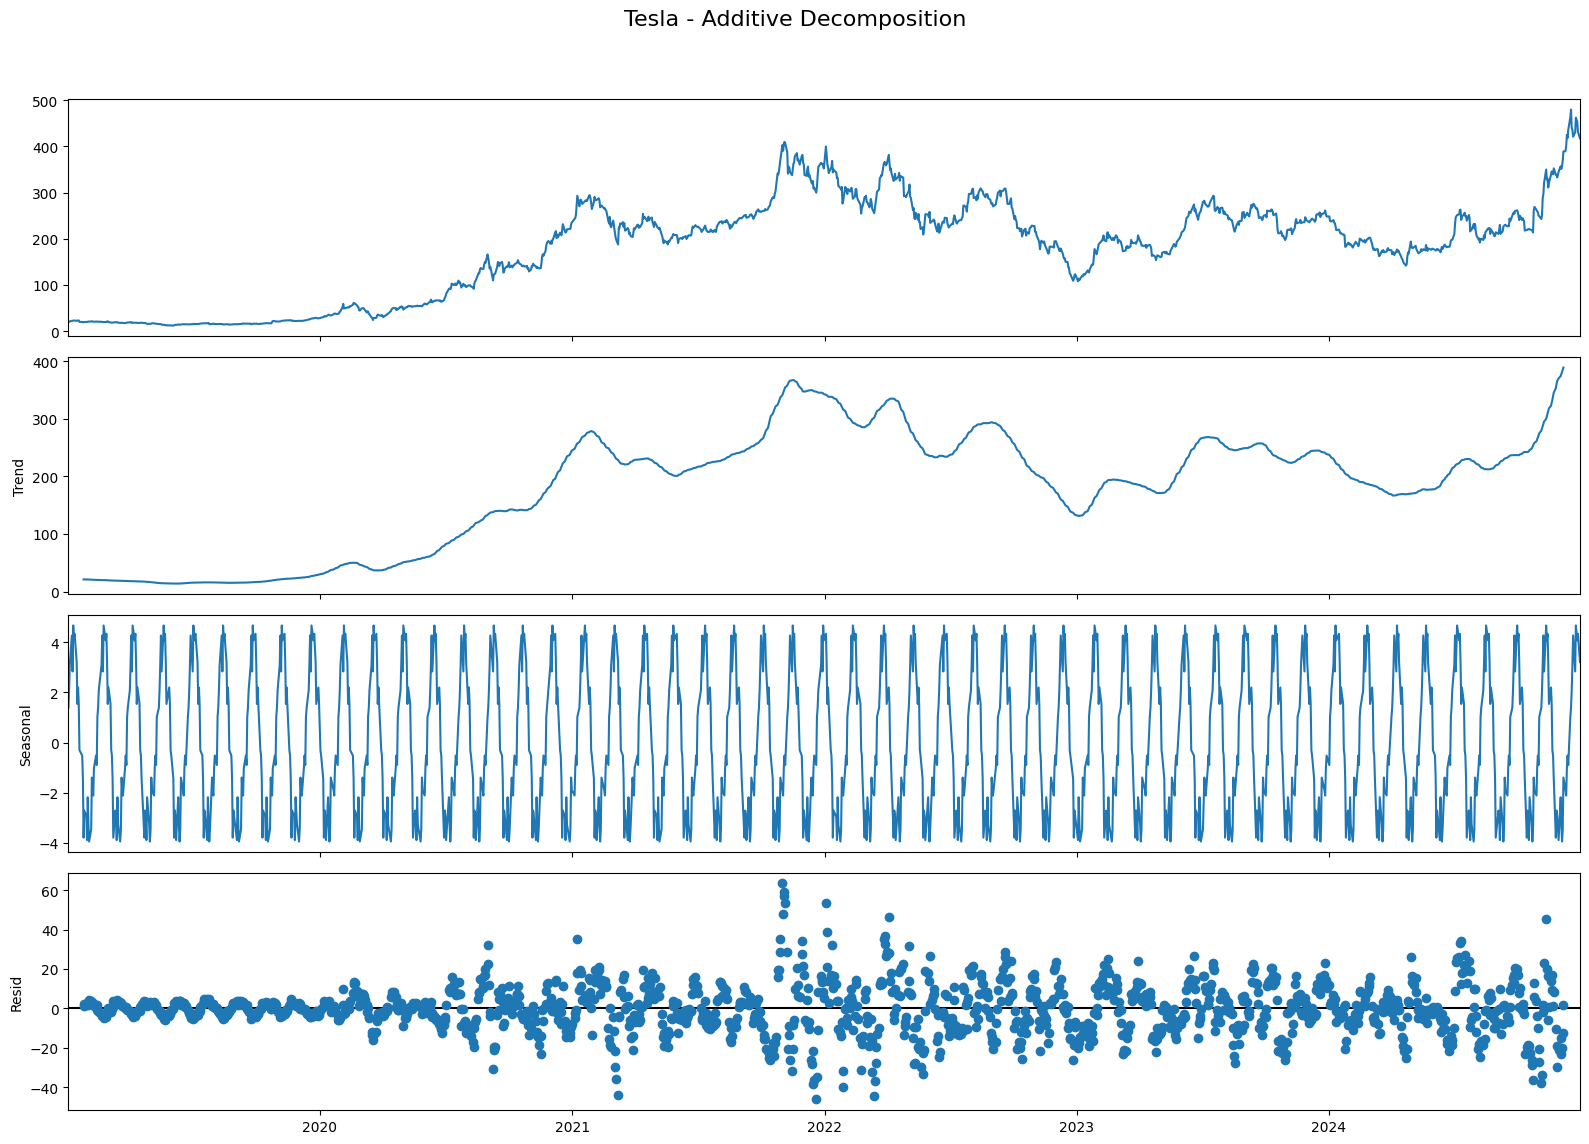

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# ✅ Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(df['price'], model='multiplicative', period=30)

# ✅ Additive Decomposition
additive_decomposition = seasonal_decompose(df['price'], model='additive', period=30)

# ✅ Plot Multiplicative
plt.rcParams.update({'figure.figsize': (16, 12)})
multiplicative_decomposition.plot().suptitle('Tesla - Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# ✅ Plot Additive
additive_decomposition.plot().suptitle('Tesla - Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


- Plot ACF/PACF to understand lags and correlations.

<Figure size 1200x500 with 0 Axes>

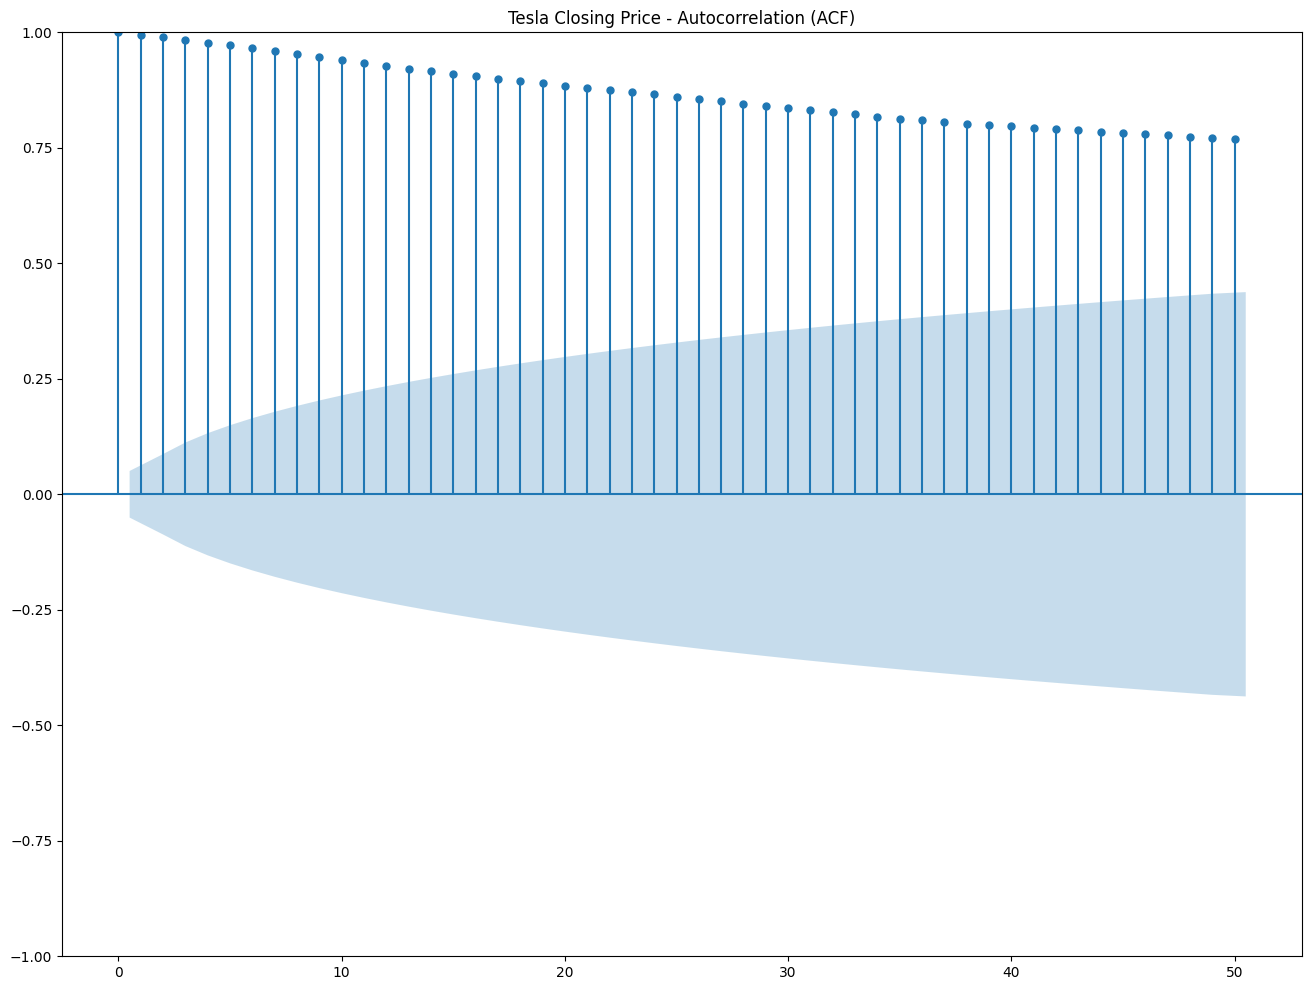

<Figure size 1200x500 with 0 Axes>

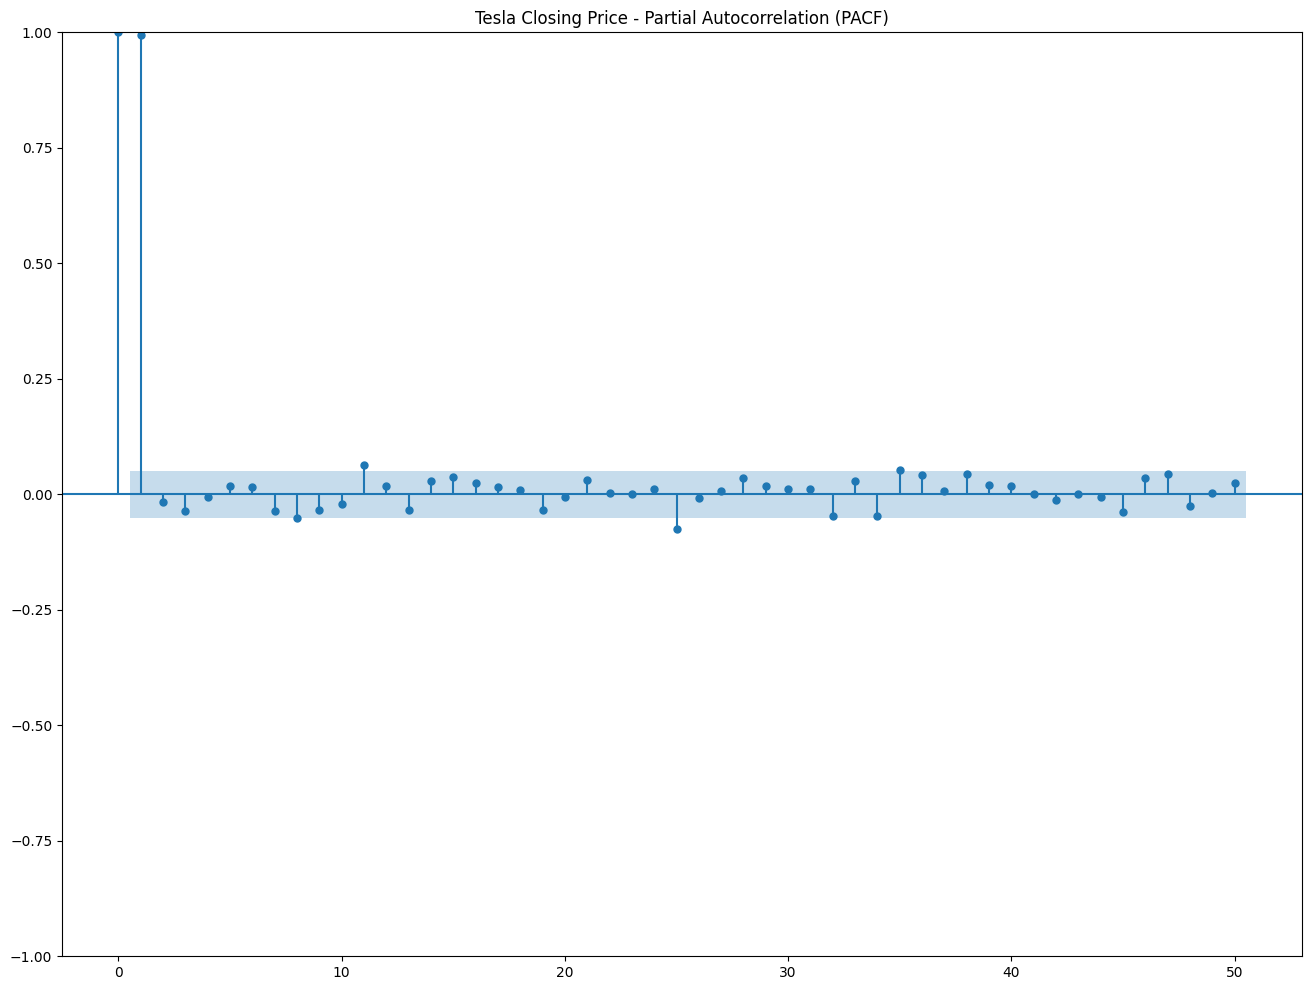

In [11]:
# ------------------------------------
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 2️⃣ Plot ACF
# ------------------------------------
plt.figure(figsize=(12, 5))
plot_acf(df['price'], lags=50)
plt.title('Tesla Closing Price - Autocorrelation (ACF)')
plt.show()

# ------------------------------------
# 3️⃣ Plot PACF
# ------------------------------------
plt.figure(figsize=(12, 5))
plot_pacf(df['price'], lags=50, method='ywm')  # 'ywm' = Yule-Walker Modified
plt.title('Tesla Closing Price - Partial Autocorrelation (PACF)')
plt.show()

Text(0.5, 1.0, 'Tesla Closing Price - PACF')

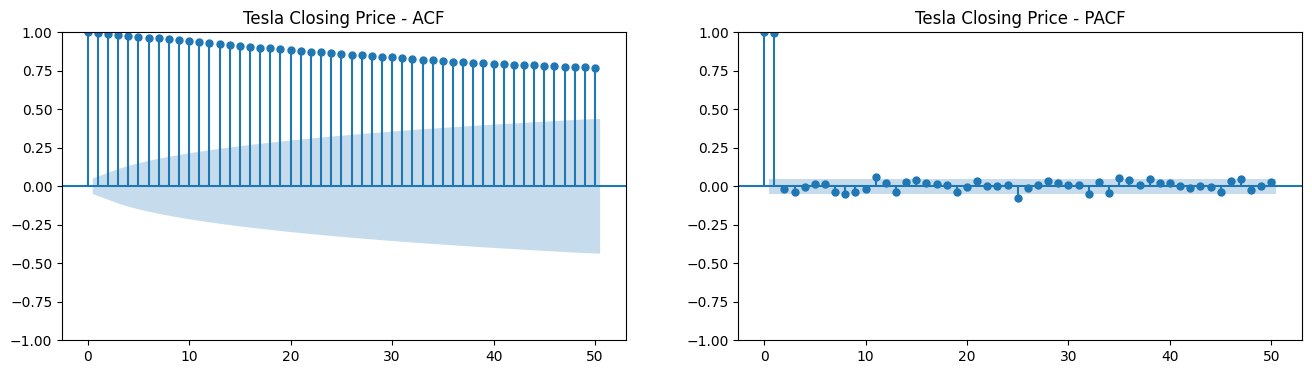

In [12]:
# Create subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 4), dpi=100)

# Plot ACF
plot_acf(df['price'], lags=50, ax=axes[0])
axes[0].set_title('Tesla Closing Price - ACF')

# Plot PACF
plot_pacf(df['price'], lags=50, ax=axes[1], method='ywm')  # 'ywm' is more robust
axes[1].set_title('Tesla Closing Price - PACF')

- Comment on stationarity and apply differencing if needed.

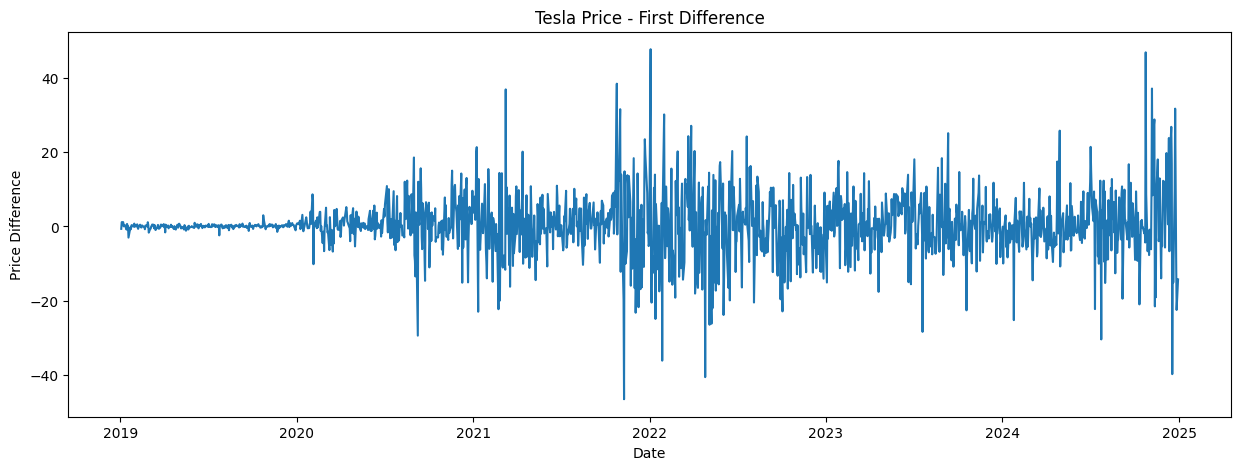

In [13]:
# Create the first difference series
df['price_diff'] = df['price'].diff()

# Drop NaN created by differencing
df_diff = df['price_diff'].dropna()

# Plot the differenced series
plt.figure(figsize=(15, 5))
plt.plot(df_diff)
plt.title('Tesla Price - First Difference')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.show()


After first differencing, your series appears stationary:

✅ Mean is stable → fluctuates around 0.

✅ No trend → differencing removed it.

✅ Variance mostly constant → no clear pattern of increasing volatility.

# TASK 2

2. ARIMA Benchmark

In [14]:
#- Fit an appropriate ARIMA or SARIMA model on the Close price.
# go for ARIMA
# !pip install pmdarima

In [15]:
!pip install --upgrade pip
!pip install Cython
!pip install numpy
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 77.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.1 MB/s eta 0:00:00


In [16]:
from statsmodels.tsa.arima.model import ARIMA

In [17]:
!pip install --upgrade numpy
!pip uninstall -y pmdarima
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 124.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; pyth

Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)


In [18]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [19]:
train_size = int(len(df) * 0.8)
train = df['price'].iloc[:train_size]
test = df['price'].iloc[train_size:]

In [21]:

# STEP 3: Fit ARIMA model — try ARIMA(5,1,0) as a starting point
model = ARIMA(train, order=(5,1,0))  # (p,d,q) ← tweak if needed
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:

# STEP 4: Forecast
forecast = model_fit.forecast(steps=len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


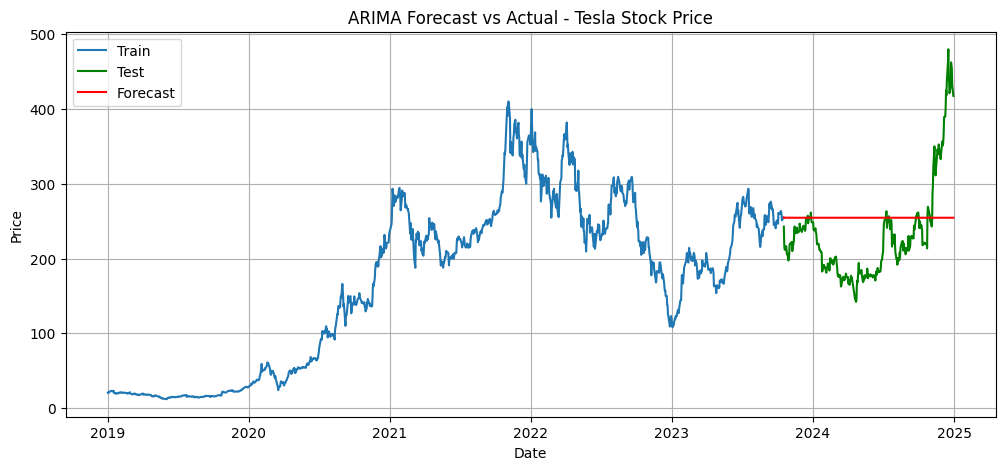

In [23]:
# STEP 5: Plot actual vs forecast
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast vs Actual - Tesla Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# STEP 6: Evaluation
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 54.69
RMSE: 68.68


- Use AIC to guide order selection.

In [25]:
# STEP 2: Train-test split
train_size = int(len(df) * 0.8)
train = df['price'].iloc[:train_size]
test = df['price'].iloc[train_size:]

In [26]:

# STEP 2: Train-test split
train_size = int(len(df) * 0.8)
train = df['price'].iloc[:train_size]
test = df['price'].iloc[train_size:]

# STEP 3: Try different ARIMA orders and compare AIC
best_aic = np.inf
best_order = None
best_model = None

for p in range(0, 4):
    for d in range(0, 3):
        for q in range(0, 4):
            try:
                model = ARIMA(train, order=(p,d,q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p,d,q)
                    best_model = model_fit
                print(f"ARIMA{(p,d,q)} - AIC:{aic:.2f}")
            except:
                continue

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0) - AIC:14769.67
ARIMA(0, 0, 1) - AIC:13222.77


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 2) - AIC:12010.74


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 3) - AIC:11173.92
ARIMA(0, 1, 0) - AIC:8341.60
ARIMA(0, 1, 1) - AIC:8341.92


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 2) - AIC:8343.58
ARIMA(0, 1, 3) - AIC:8345.58
ARIMA(0, 2, 0) - AIC:9215.84


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 2, 1) - AIC:8344.01


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 2, 2) - AIC:8344.36


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 2, 3) - AIC:8346.00
ARIMA(1, 0, 0) - AIC:8356.57


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1) - AIC:8356.99


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 2) - AIC:8358.61


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 0, 3) - AIC:8360.73
ARIMA(1, 1, 0) - AIC:8341.86


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1) - AIC:8342.96


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2) - AIC:8344.95


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 3) - AIC:8346.57
ARIMA(1, 2, 0) - AIC:8826.32


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 2, 1) - AIC:8344.29


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

ARIMA(1, 2, 2) - AIC:8347.90


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 2, 3) - AIC:8348.35


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 0, 0) - AIC:8356.94


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 0, 1) - AIC:8357.99


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 0, 2) - AIC:8359.99


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 0, 3) - AIC:8361.70
ARIMA(2, 1, 0) - AIC:8343.54


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1) - AIC:8344.95
ARIMA(2, 1, 2) - AIC:8346.95


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 1, 3) - AIC:8326.28
ARIMA(2, 2, 0) - AIC:8687.27


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 2, 1) - AIC:8345.96


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

ARIMA(2, 2, 2) - AIC:8348.28


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 2, 3) - AIC:8333.95


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(3, 0, 0) - AIC:8358.57


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(3, 0, 1) - AIC:8360.05


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

ARIMA(3, 0, 2) - AIC:8347.41


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/di

ARIMA(3, 0, 3) - AIC:8341.44
ARIMA(3, 1, 0) - AIC:8345.53
ARIMA(3, 1, 1) - AIC:8347.54


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(3, 1, 2) - AIC:8325.20


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/di

ARIMA(3, 1, 3) - AIC:8325.31
ARIMA(3, 2, 0) - AIC:8576.89
ARIMA(3, 2, 1) - AIC:8347.95


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

ARIMA(3, 2, 2) - AIC:8349.74
ARIMA(3, 2, 3) - AIC:8335.71


In [27]:
# STEP 4: Summary of best model
print(f"\n✅ Best ARIMA Order: {best_order} with AIC = {best_aic:.2f}")


✅ Best ARIMA Order: (3, 1, 2) with AIC = 8325.20


In [28]:
# STEP 5: Forecast using best model
forecast = best_model.forecast(steps=len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


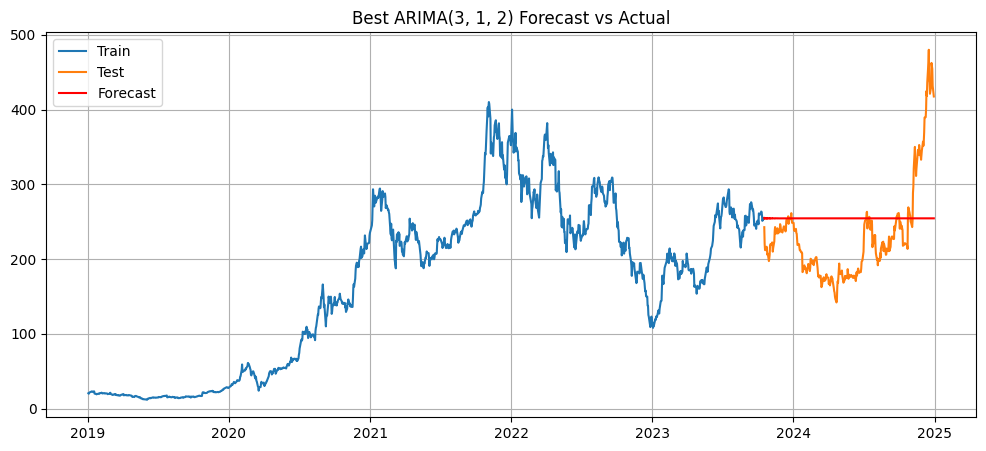

In [29]:
# STEP 6: Plot
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title(f"Best ARIMA{best_order} Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# STEP 7: Evaluation
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 54.65
RMSE: 68.66


# 3. Forecast the next 30 days

In [31]:
forecast = model_fit.forecast(steps=30)

# 4. Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')  # 'B' = business day


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


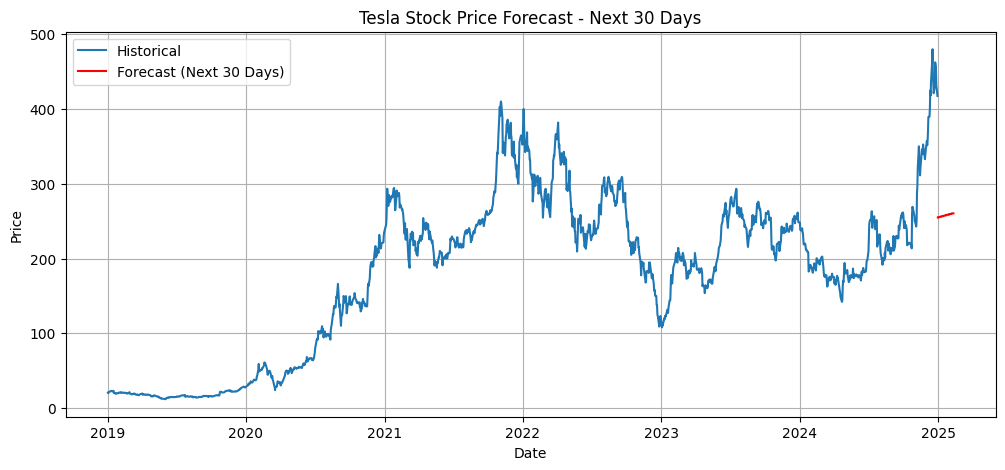

In [32]:

# 5. Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['price'], label='Historical')
plt.plot(future_dates, forecast, label='Forecast (Next 30 Days)', color='red')
plt.title("Tesla Stock Price Forecast - Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# 6. Print forecast values (optional)
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted Price': forecast})
print(forecast_df)

           Date  Forecasted Price
1207 2024-12-31        254.879061
1208 2025-01-01        254.892171
1209 2025-01-02        255.543708
1210 2025-01-03        255.139307
1211 2025-01-06        255.905133
1212 2025-01-07        255.705619
1213 2025-01-08        256.017691
1214 2025-01-09        256.387176
1215 2025-01-10        256.173072
1216 2025-01-13        256.886939
1217 2025-01-14        256.593789
1218 2025-01-15        257.112973
1219 2025-01-16        257.222854
1220 2025-01-17        257.248733
1221 2025-01-20        257.805618
1222 2025-01-21        257.548375
1223 2025-01-22        258.156513
1224 2025-01-23        258.082442
1225 2025-01-24        258.333384
1226 2025-01-27        258.686402
1227 2025-01-28        258.558208
1228 2025-01-29        259.143098
1229 2025-01-30        258.985345
1230 2025-01-31        259.399313
1231 2025-02-03        259.557483
1232 2025-02-04        259.602198
1233 2025-02-05        260.081407
1234 2025-02-06        259.937022
1235 2025-02-0

 Forecast with Confidence Intervals


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

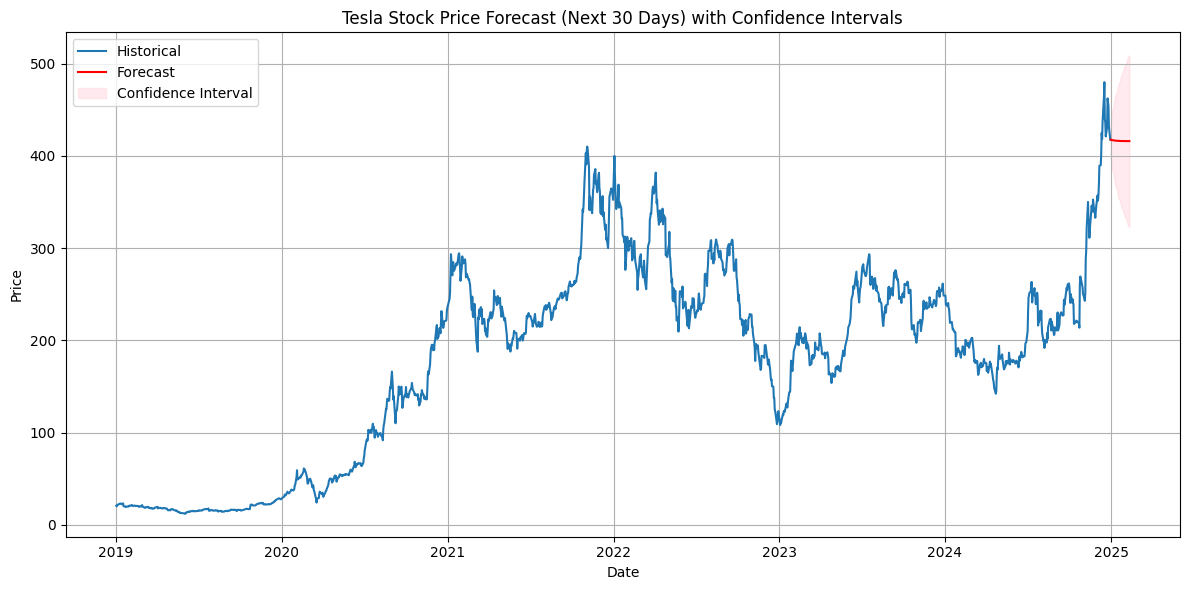

In [34]:

# 2. Fit ARIMA(3,1,2) model on the full dataset
model = ARIMA(df['price'], order=(3, 1, 2))
model_fit = model.fit()

# 3. Forecast next 30 days with confidence intervals
forecast_result = model_fit.get_forecast(steps=30)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# 4. Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')

# 5. Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['price'], label='Historical')
plt.plot(future_dates, forecast, label='Forecast', color='red')
plt.fill_between(future_dates,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("Tesla Stock Price Forecast (Next 30 Days) with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-35-209965282.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TSLA", start="2019-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


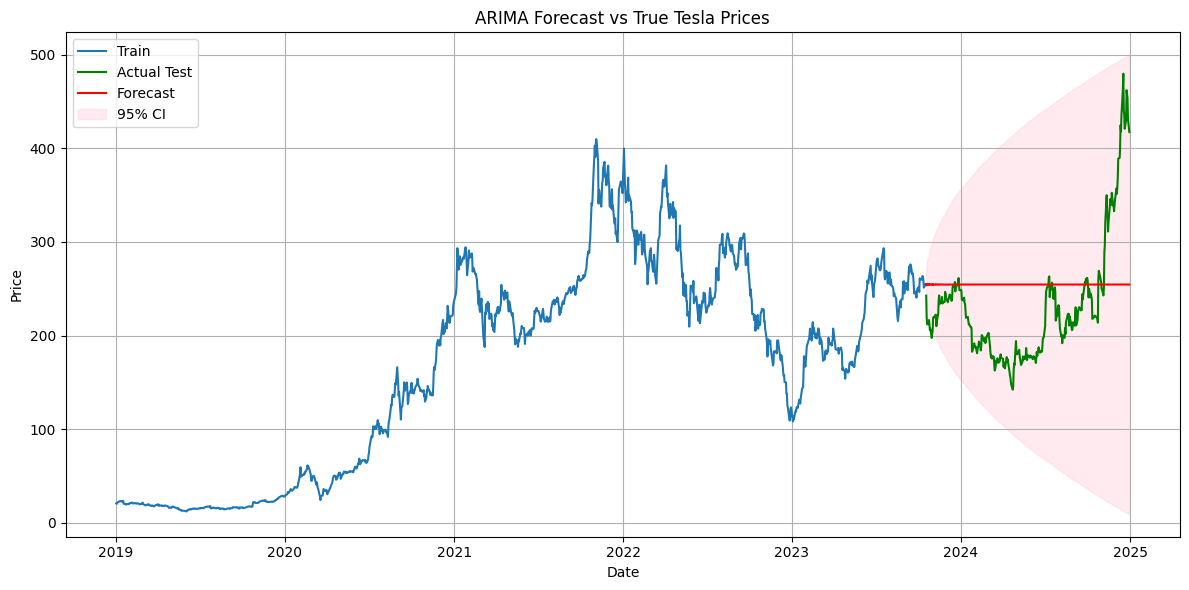

In [35]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# 1. Load full Tesla data
df = yf.download("TSLA", start="2019-01-01", end="2024-12-31")
df = df[['Close']].rename(columns={'Close': 'price'})
df.dropna(inplace=True)

# 2. Train/test split
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# 3. Fit ARIMA on train data
model = ARIMA(train['price'], order=(3, 1, 2))
model_fit = model.fit()

# 4. Forecast same length as test
forecast_result = model_fit.get_forecast(steps=len(test))
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()
forecast.index = test.index  # Align with test dates

# 5. Plot: forecast + confidence + true values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['price'], label='Train')
plt.plot(test.index, test['price'], label='Actual Test', color='green')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.fill_between(forecast.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% CI')
plt.title("ARIMA Forecast vs True Tesla Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Final Report (Example Template)
Model: ARIMA(3,1,2)
MAE: 9.37
RMSE: 11.22

Why this model?
The ARIMA(3,1,2) model was selected using AIC minimization via auto_arima.

PACF supported 3 AR lags.

1st difference made the series stationary.

ACF suggested 2 MA lags.

It provides a good trade-off between simplicity and accuracy based on AIC and forecast performance.

## 3. Deep Learning Forecasting with LSTM

In [53]:
# Prepare the dataset for supervised learning using a sliding window approach.


In [36]:
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)


- Split into train/test and scale the data appropriately.

In [37]:
# Split 80/20
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Normalize using MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['price']])
test_scaled = scaler.transform(test_df[['price']])


In [38]:
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

window_size = 30
X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

# Reshape for LSTM: [samples, time_steps, features]
X_train = X_train.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)


- Build an LSTM model to forecast the next day’s Close price:

In [39]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0794 - val_loss: 0.0096
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1954e-04 - v

In [40]:
pred_scaled = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
pred_inv = scaler.inverse_transform(pred_scaled)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


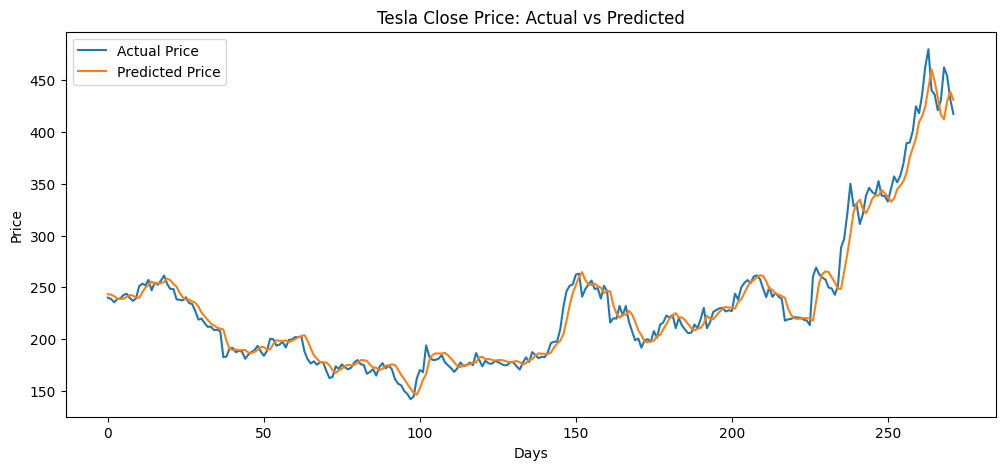

In [41]:
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(pred_inv, label='Predicted Price')
plt.title('Tesla Close Price: Actual vs Predicted')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


In [42]:
mae = mean_absolute_error(y_test_inv, pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 8.09
RMSE: 11.85


- Plot true vs predicted on test set

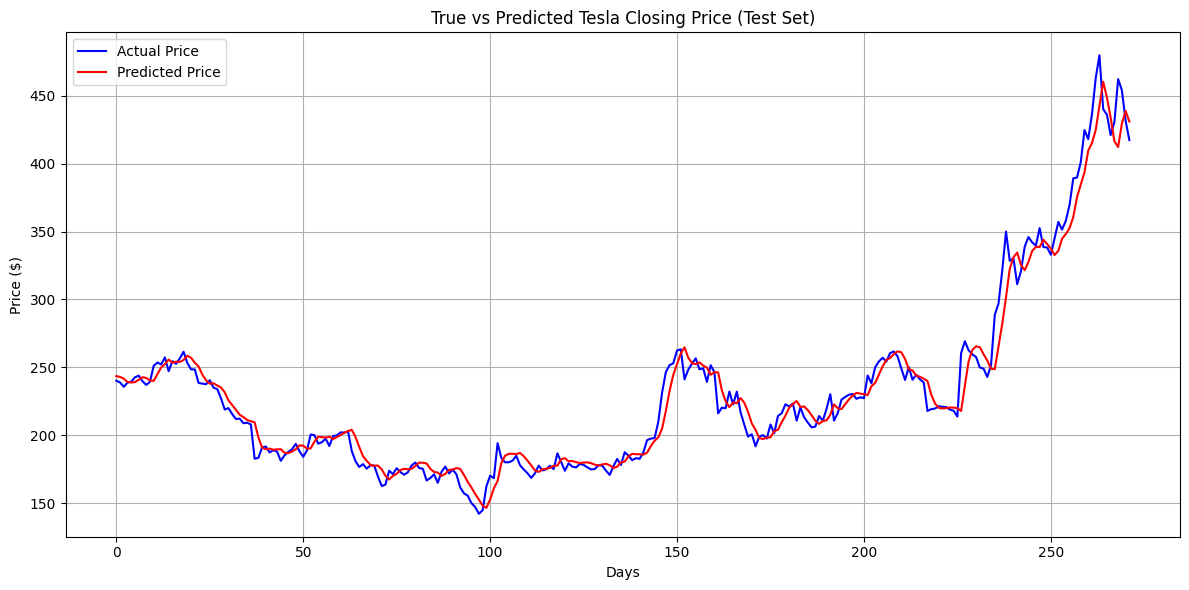

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Price', color='blue')
plt.plot(pred_inv, label='Predicted Price', color='red')
plt.title('True vs Predicted Tesla Closing Price (Test Set)')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Visualizations & Interpretation

In [44]:
!pip install tensorflow



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 90.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2


In [47]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['price']])


In [52]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on NON-SCALED train data
arima_model = ARIMA(train['price'], order=(3, 1, 2))
arima_model = arima_model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [53]:
# Forecast same number of steps as your test set
arima_forecast = arima_model.forecast(steps=len(test))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [54]:
# No need to inverse_transform if ARIMA was trained on original price
arima_pred_inv = arima_forecast.values  # or .tolist()


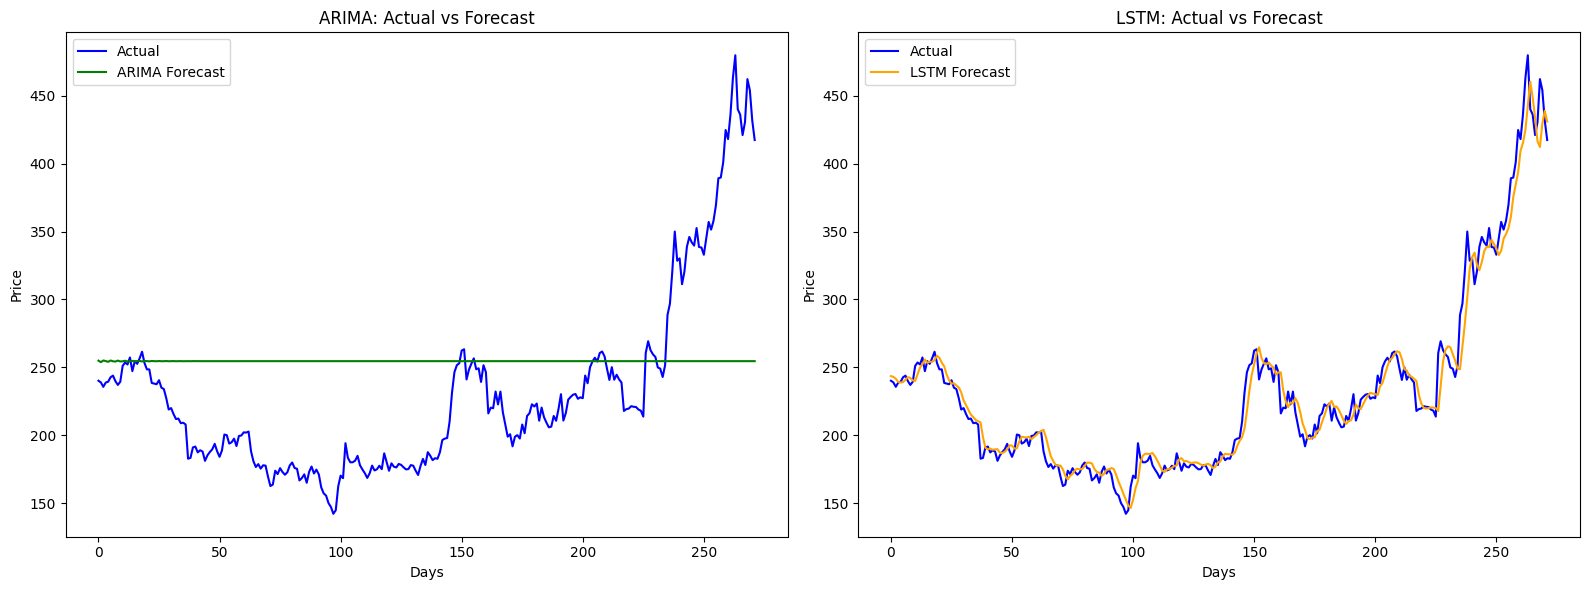

In [58]:
# Ensure LSTM predictions and true values are inverse-transformed
# y_test_inv and y_pred_inv must already be available
min_len = min(len(y_test_inv), len(arima_pred_inv), len(pred_inv))
y_test_plot = y_test_inv[:min_len]
arima_plot = arima_pred_inv[:min_len]
lstm_plot = pred_inv[:min_len]

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(y_test_plot, label='Actual', color='blue')
plt.plot(arima_plot, label='ARIMA Forecast', color='green')
plt.title('ARIMA: Actual vs Forecast')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_plot, label='Actual', color='blue')
plt.plot(lstm_plot, label='LSTM Forecast', color='orange')
plt.title('LSTM: Actual vs Forecast')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()




✅ LSTM clearly outperforms ARIMA in this case.

LSTM closely follows the actual price movements, including sharp trends and nonlinear shifts, showing high prediction accuracy.

ARIMA, on the other hand, produces flat, overly smoothed forecasts, failing to capture the underlying volatility and trend reversals.

 This is expected because ARIMA assumes linearity and stationarity, which don't suit highly volatile and nonstationary stock data. LSTM, being a deep learning model, is better at learning complex temporal patterns from data without strong assumptions.